<a href="https://colab.research.google.com/github/87tana/Image-Semantic-Segmentation/blob/main/Tumor_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Set up environment

In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)


Mounted at /content/drive/


In [2]:
cd '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/'

/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation


In [3]:
# Path to dataset
root_dir = '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/Tumor_Segmentation'


In [4]:
import os
import cv2
import json
import random
from PIL import Image
import pandas as pd
import numpy as np
import skimage.draw

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import skimage  # import scikit_image
import tifffile  # for reading and writing TIFF
import shutil #Higher-level interface for file operations, including file copying, removal, and archiving

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
# from torchvision.datasets import YourDatasetClass


# 2. Data Prepration

## 2.1. Creating DataFrame

In [7]:
set(data)

{'annotations', 'categories', 'images', 'info', 'licenses'}

In [5]:
file_name = []
width = []
height = []
category_id = []
segmentation = []
subset = []

for s in ['train', 'valid', 'test']:
  with open(os.path.join(root_dir,s,'_annotations.coco.json'),'r') as file:
    data = json.load(file)
    for id in range(len(data['images'])):
      # Flag to check the annotation availability
      ann_available=False
      # Look for the corresponding annotation
      for j in range(id,len(data['images'])):
        if data['annotations'][j]['image_id'] == data['images'][id]['id']:
          category_id.append(data['annotations'][j]['category_id'])
          segmentation.append(data['annotations'][j]['segmentation'])
          ann_available=True
          break

      if ann_available:
        file_name.append(data['images'][id]['file_name'])
        width.append(data['images'][id]['width'])
        height.append(data['images'][id]['height'])
        subset.append(s)
      else:
        print(f'Annotation is missing for image {id} in {s}')



dic = {'file_name': file_name, 'width': width , 'height': height,\
        'category_id': category_id, 'segmentation': segmentation, 'subset': subset}



Annotation is missing for image 1380 in train


To handle the dataset, we initialize a dataframe and extract crucial details from it. This involves parsing annotations stored in JSON files for each subset of the dataset (train, valid, test). For each image, the program locates the corresponding annotation, retrieves pertinent data, and organizes it into lists. In case an annotation is absent for an image, a warning message is printed. Finally, a dictionary named 'dic' is constructed, consolidating all the extracted information.

In [6]:
df = pd.DataFrame.from_dict(dic)
df.head()

,file_name,width,height,category_id,segmentation,subset
0,2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg,640,640,1,"[[313.75, 238.75, 145, 238.75, 145, 401.25, 31...",train
1,2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg,640,640,1,"[[342.5, 176.25, 193.75, 176.25, 193.75, 410, ...",train
2,2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg,640,640,1,"[[295, 172.5, 132.5, 172.5, 132.5, 357.5, 295,...",train
3,2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg,640,640,1,"[[383.75, 357.5, 245, 357.5, 245, 523.75, 383....",train
4,2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg,640,640,1,"[[192.5, 188.75, 80, 188.75, 80, 321.25, 192.5...",train


In [7]:
def create_mask(image_info):

  """ - The function aims to create a binary mask based on the segmentation information provided.
        It iterates over each segmentation entry in the image_info['segmentation'] list.
        it extracts the polygon coordinates from the segmentation list.
        pixels inside the segmented regions are set to 1 and pixels outside are set to 0.
  """
  mask_np = np.zeros((image_info['height'],image_info['width']),dtype=np.uint8)

  for seg_idx ,seg in enumerate(image_info['segmentation']):
      rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
      mask_np[rr,cc]=1

  return mask_np

## 2.2 Data Images Glimpse, Class 1 and Class 2 are both Tumor

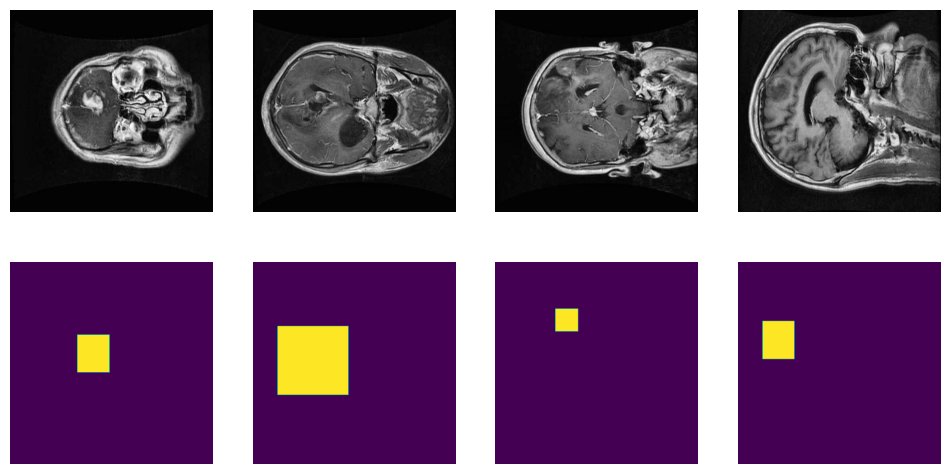

In [9]:
samp = df[df['category_id']==1].sample(4).reset_index(drop=True)

fig, axes = plt.subplots (2,4,figsize=(12,6))

for i in range(len(samp)): # index and image path
    img = mpimg.imread(os.path.join(root_dir,samp.loc[i]['subset'],samp.loc[i]['file_name']))
    axes[0,i].imshow(img)
    axes[0,i].axis('off') # Turn off axis labels
    mask = create_mask(samp.loc[i])
    axes[1,i].imshow(mask)
    axes[1,i].axis('off') # Turn off axis labels

plt.show()


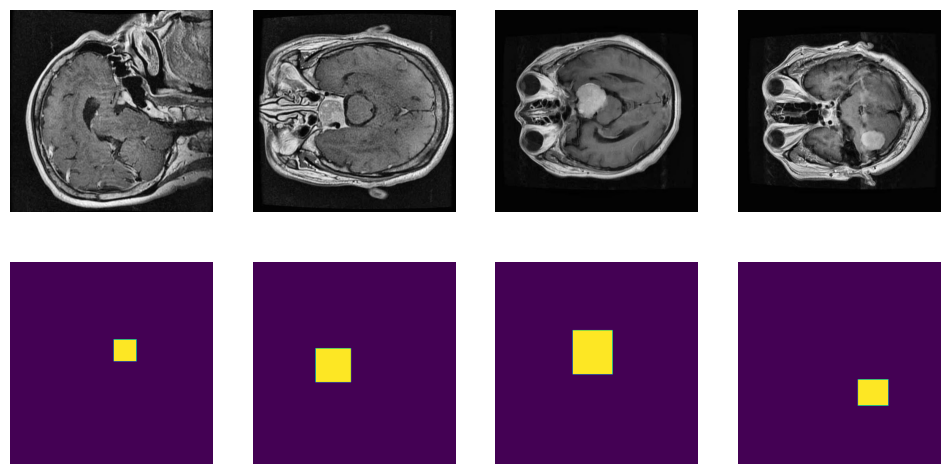

In [10]:
samp = df[df['category_id']==2].sample(4).reset_index(drop=True)

fig, axes = plt.subplots (2,4,figsize=(12,6))

for i in range(len(samp)): # index and image path
    img = mpimg.imread(os.path.join(root_dir,samp.loc[i]['subset'],samp.loc[i]['file_name']))
    axes[0,i].imshow(img)
    axes[0,i].axis('off') # Turn off axis labels
    mask = create_mask(samp.loc[i])
    axes[1,i].imshow(mask)
    axes[1,i].axis('off') # Turn off axis labels

plt.show()

In [45]:
class SegmentationDataset():
    def __init__(self, root_dir, df, subset, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.data_ = []

        for i in tqdm(range(10)):#tqdm(range(len(df))):
          img = cv2.imread(os.path.join(root_dir,subset,df.loc[i]['file_name']))
          mask = create_mask(df.loc[i]) # Create mask
          self.data_.append({'image': img, 'mask': mask}) # add image and its mask to a list.

    def __len__(self):
        return len(self.data_)

    def __getitem__(self, idx):

        image = self.data_[idx]['image']
        mask = self.data_[idx]['mask']

        if self.transform is not None:
          image = self.transform['image'](image)
          mask = self.transform['mask'](mask)

        return image, mask

In [46]:
transform_img= transforms.Compose([transforms.ToTensor()])
transform_mask = transforms.Compose([transforms.ToTensor(),transforms.Resize((80, 80))])
transform = {'image': transform_img, 'mask': transform_mask}

train_dataset = SegmentationDataset(root_dir=root_dir, df=df[df['subset']=='train'], subset='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)


100%|██████████| 10/10 [00:00<00:00, 53.90it/s]


In [ ]:
train_dataset.data_[0]['image']

In [ ]:
train_dataset.data_[0]['mask']*255

In [13]:
# Define the CNN model for segmentation
class SegmentationCNN(nn.Module):
    def __init__(self):
        super(SegmentationCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 1, 3, padding=1)  # Output is a single channel for binary segmentation
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.conv4(x)
        return x

In [14]:
# Initialize the model, loss function, and optimizer
model = SegmentationCNN()
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SegmentationCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

In [47]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:

        images, masks = images.to(device), masks.to(device)

        outputs = model(images)

        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 0.5962
Epoch [2/10], Loss: 0.4854
Epoch [3/10], Loss: 0.3397
Epoch [4/10], Loss: 0.1930
Epoch [5/10], Loss: 0.0930
Epoch [6/10], Loss: 0.0413
Epoch [7/10], Loss: 0.0184
Epoch [8/10], Loss: 0.0092
Epoch [9/10], Loss: 0.0059
Epoch [10/10], Loss: 0.0051


In [ ]:
# Define your dataset and dataloaders
#transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

#transform = transforms.Compose([transforms.ToTensor()])

#train_dataset = SegmentationDataset(root_dir=root_dir, df=df[df['subset']=='train'], subset='train', transform=transform)


#valid_dataset = SegmentationDataset(train=True, transform=transform)
#test_dataset = SegmentationDataset(train=False, transform=transform)

#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
model = SegmentationCNN()
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Testing loop
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        test_loss += criterion(outputs, masks).item() * images.size(0)

avg_test_loss = test_loss / len(test_loader.dataset)
print(f"Average Test Loss: {avg_test_loss:.4f}")